### __Анализ конверсий пазлов (картинок)__  
Период с 01.03.22 по 05.05.22

In [113]:
import pandas as pd
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


Загружаем данные из файла выгрузки Яндекса

In [160]:
data=pd.read_csv('events.csv')
data

,event_name,event_json,event_datetime
0,game_puzzle_pause,"{""puzzle_id"":""33"",""Order_number"":""1"",""category...",2022-05-05 23:08:45
1,game_puzzle_pause,"{""puzzle_id"":""33"",""Order_number"":""1"",""category...",2022-05-05 23:09:33
2,session_pause,"{""balance"":""555"",""days_in_game"":""0"",""PuzzleCom...",2022-05-05 23:08:45
3,session_pause,"{""balance"":""555"",""days_in_game"":""0"",""PuzzleCom...",2022-05-05 23:09:33
4,session_resume,"{""balance"":""555"",""days_in_game"":""0"",""PuzzleCom...",2022-05-05 23:09:28
...,...,...,...
23473630,ui_screen,"{""Prev"":""MainScreenState"",""Next"":""Achievements...",2022-03-22 06:08:22
23473631,ui_screen,"{""Prev"":""EmptyState"",""Next"":""MainScreenState"",...",2022-03-22 11:23:00
23473632,ui_screen,"{""Prev"":""MainScreenState"",""Next"":""StartPuzzleP...",2022-03-22 11:23:16
23473633,ui_screen,"{""Prev"":""MainScreenState"",""Next"":""LoadingScree...",2022-03-22 11:23:17


Оставляем только интересующие нас события/event_name, связанные с пазлами, а именно: 'show_image', 'game_puzzle_start', 'game_puzzle_complete', 'game_puzzle_quit'

In [161]:
data=data[data['event_name'].isin(['show_image', 'game_puzzle_start', 'game_puzzle_complete', 'game_puzzle_quit'])].reset_index(drop=True)
data

,event_name,event_json,event_datetime
0,game_puzzle_complete,"{""puzzle_id"":""19"",""Order_number"":""19"",""categor...",2022-04-26 23:56:14
1,show_image,"{""category_id"":""13"",""puzzle_id"":""19"",""Order_nu...",2022-04-26 23:52:50
2,show_image,"{""category_id"":""31"",""puzzle_id"":""89"",""Order_nu...",2022-05-02 14:42:59
3,show_image,"{""category_id"":""31"",""puzzle_id"":""89"",""Order_nu...",2022-05-02 14:42:59
4,show_image,"{""category_id"":""31"",""puzzle_id"":""89"",""Order_nu...",2022-05-02 21:54:36
...,...,...,...
3433168,show_image,"{""category_id"":""3"",""puzzle_id"":""49"",""Order_num...",2022-03-22 11:23:13
3433169,show_image,"{""category_id"":""1"",""puzzle_id"":""23"",""Order_num...",2022-03-22 11:23:13
3433170,show_image,"{""category_id"":""1"",""puzzle_id"":""33"",""Order_num...",2022-03-22 11:23:14
3433171,show_image,"{""category_id"":""11"",""puzzle_id"":""7"",""Order_num...",2022-03-22 11:23:15


Уберем дубликаты (не понятна их природа, но они есть)

In [145]:
#data.drop_duplicates(inplace=True)

Вынимаем из data.event_json информацию в читаемый/преобразуемый вид

In [162]:
data_json = pd.json_normalize(list(map(json.loads, data.event_json)))
data_json.head()

,puzzle_id,Order_number,category_id,Rotate,Difficulty,PuzzleStart,PuzzleComplete,completed,background,place,balance,days_in_game,started,Continue,available,Progress,Percent,Concat,Placed,puzzle_uid
0,19,19,13,0,49,13,7,0,3,inprogress,720,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,19,19,13,NaN,NaN,12,6,0,NaN,in_progress,720,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,89,77,31,NaN,NaN,77,18,0,NaN,in_progress,3490,42,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,89,77,31,NaN,NaN,77,18,0,NaN,in_progress,3490,42,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,89,77,31,NaN,NaN,78,18,0,NaN,in_progress,3490,43,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Формируем dataframe c событиями и пазлами. Добавляем столбец puzz_cat_id, который будет однозначно идентифицировать puzzle_id. В нем: IDпазла_IDкатегории

In [163]:
data_w = data[['event_name', 'event_datetime']]
data_w['puzz_cat_id'] = data_json.puzzle_id.astype(str) + '_' + data_json.category_id.astype(str)

Формируем фреймы с подсчетами участия пазлов, по событиям.

In [164]:
show_image = data_w.query('event_name=="show_image"').groupby(by='puzz_cat_id').count()
show_image.drop('event_datetime', axis=1, inplace=True)
show_image.rename(columns={'event_name':'show_image'}, inplace=True)
show_image.reset_index(inplace=True)

game_puzzle_start = data_w.query('event_name=="game_puzzle_start"').groupby(by='puzz_cat_id').count()
game_puzzle_start.drop('event_datetime', axis=1, inplace=True)
game_puzzle_start.rename(columns={'event_name':'game_puzzle_start'}, inplace=True)
game_puzzle_start.reset_index(inplace=True)

game_puzzle_complete = data_w.query('event_name=="game_puzzle_complete"').groupby(by='puzz_cat_id').count()
game_puzzle_complete.drop('event_datetime', axis=1, inplace=True)
game_puzzle_complete.rename(columns={'event_name':'game_puzzle_complete'}, inplace=True)
game_puzzle_complete.reset_index(inplace=True)

game_puzzle_quit = data_w.query('event_name=="game_puzzle_quit"').groupby(by='puzz_cat_id').count()
game_puzzle_quit.drop('event_datetime', axis=1, inplace=True)
game_puzzle_quit.rename(columns={'event_name':'game_puzzle_quit'}, inplace=True)
game_puzzle_quit.reset_index(inplace=True)

Вот они:

In [166]:
show_image.head()


,puzz_cat_id,show_image
0,100_1,1621
1,100_31,2507
2,10_1,3204
3,10_10,1917
4,10_11,2346


In [167]:
game_puzzle_start.head()

,puzz_cat_id,game_puzzle_start
0,100_1,79
1,100_31,113
2,10_1,130
3,10_10,71
4,10_11,65


In [168]:
game_puzzle_complete.head()

,puzz_cat_id,game_puzzle_complete
0,100_1,71
1,100_31,114
2,10_1,117
3,10_10,56
4,10_11,53


In [169]:
game_puzzle_quit.head()

,puzz_cat_id,game_puzzle_quit
0,100_1,1
1,100_31,6
2,10_1,8
3,10_10,14
4,10_11,8


#### Объединим фреймы в один и посчитаем конверсии по пазлам. (обращаем внимание - есть странные конверсии > 100%)

In [182]:
data_count = show_image.merge(game_puzzle_start, how='left').merge(game_puzzle_complete, how='left').merge(game_puzzle_quit, how='left')

In [183]:
data_count['conv_show_to_start'] = round (data_count['game_puzzle_start'] / data_count['show_image'] * 100, 2)
data_count['conv_show_to_complete'] = round (data_count['game_puzzle_complete'] / data_count['show_image'] * 100, 2)
data_count['conv_start_to_complete'] = round (data_count['game_puzzle_complete'] / data_count['game_puzzle_start'] * 100, 2)
data_count['conv_start_to_quit'] = round (data_count['game_puzzle_quit'] / data_count['game_puzzle_start'] * 100, 2)
data_count.fillna(0)
data_count

,puzz_cat_id,show_image,game_puzzle_start,game_puzzle_complete,game_puzzle_quit,conv_show_to_start,conv_show_to_complete,conv_start_to_complete,conv_start_to_quit
0,100_1,1621,79.0,71.0,1.0,4.87,4.38,89.87,1.27
1,100_31,2507,113.0,114.0,6.0,4.51,4.55,100.88,5.31
2,10_1,3204,130.0,117.0,8.0,4.06,3.65,90.00,6.15
3,10_10,1917,71.0,56.0,14.0,3.70,2.92,78.87,19.72
4,10_11,2346,65.0,53.0,8.0,2.77,2.26,81.54,12.31
...,...,...,...,...,...,...,...,...,...
1330,9_37,2955,117.0,95.0,29.0,3.96,3.21,81.20,24.79
1331,9_4,1934,77.0,72.0,4.0,3.98,3.72,93.51,5.19
1332,9_6,2189,102.0,87.0,13.0,4.66,3.97,85.29,12.75
1333,9_7,1930,71.0,62.0,6.0,3.68,3.21,87.32,8.45


Гистограмма конверсии SHOW in START

<AxesSubplot:>

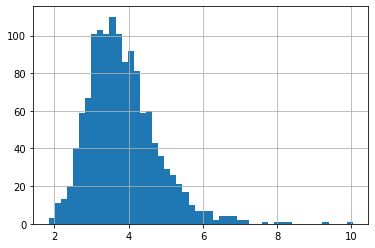

In [172]:
data_count['conv_show_to_start'].hist(bins=50)

Гистограмма конверсии START in COMPLETE

<AxesSubplot:>

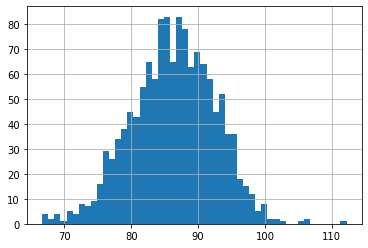

In [173]:
data_count['conv_start_to_complete'].hist(bins=50)

Гистограмма START in QUIT

<AxesSubplot:>

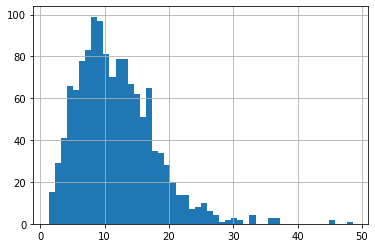

In [177]:
data_count['conv_start_to_quit'].hist(bins=50)

#### Пример таблицы с сортировкой по признаку конверсии SHOW to START

In [176]:
data_count.sort_values('conv_show_to_start', ascending=False).head(30)

,puzz_cat_id,show_image,game_puzzle_start,game_puzzle_complete,game_puzzle_quit,conv_show_to_start,conv_show_to_complete,conv_start_to_complete,conv_start_to_quit
1303,99_1,7310,734.0,508.0,133.0,10.04,6.95,69.21,18.12
1288,91_31,1068,100.0,97.0,2.0,9.36,9.08,97.00,2.00
1296,95_31,1066,88.0,75.0,3.0,8.26,7.04,85.23,3.41
1100,64_1,8796,721.0,551.0,113.0,8.20,6.26,76.42,15.67
1011,53_1,1486,119.0,111.0,7.0,8.01,7.47,93.28,5.88
668,31_1,1115,86.0,84.0,3.0,7.71,7.53,97.67,3.49
788,39_1,948,68.0,57.0,5.0,7.17,6.01,83.82,7.35
1253,89_31,1664,119.0,114.0,15.0,7.15,6.85,95.80,12.61
316,1_31,6513,460.0,375.0,78.0,7.06,5.76,81.52,16.96
262,18_35,2871,201.0,155.0,33.0,7.00,5.40,77.11,16.42


#### Пример таблицы с сортировкой по признаку конверсии START to COMPLETE

In [184]:
data_count.sort_values('conv_start_to_complete', ascending=False).head(30)

,puzz_cat_id,show_image,game_puzzle_start,game_puzzle_complete,game_puzzle_quit,conv_show_to_start,conv_show_to_complete,conv_start_to_complete,conv_start_to_quit
638,2_7,1163,41.0,46.0,1.0,3.53,3.96,112.20,2.44
179,15_7,1159,32.0,34.0,2.0,2.76,2.93,106.25,6.25
1123,69_7,1036,34.0,36.0,1.0,3.28,3.47,105.88,2.94
550,27_4,1833,58.0,61.0,3.0,3.16,3.33,105.17,5.17
1010,52_7,1626,43.0,44.0,3.0,2.64,2.71,102.33,6.98
90,12_7,1811,55.0,56.0,1.0,3.04,3.09,101.82,1.82
993,50_7,1942,65.0,66.0,6.0,3.35,3.40,101.54,9.23
1190,79_1,2920,83.0,84.0,7.0,2.84,2.88,101.20,8.43
1,100_31,2507,113.0,114.0,6.0,4.51,4.55,100.88,5.31
1235,83_31,1571,79.0,79.0,7.0,5.03,5.03,100.00,8.86


Вопросы себе/тебе:  
1. Какие еще могут быть/есть события с пазлом, кроме start, complete, quit ? Почему не бьется математика: complete + quit != start  
2. Что происходит если пользователь начинает пазл, но например приходит входящий звонок, он отвлекается и возвращаяется к нему пазлу/игре на следующий день ? Это фиксируется как quit ? 
3. Как фиксируется "брошенный" пазл ? Пользователь начал, бросил/отвлекся, на следующий день начал другой.... (по нему случился start и не случился complete !?)
4. Можно ли объяснить природу конверсии старта в комплит более 100% тем, что 100+ дают пазлы начатые до отчетного периода и законченые во время него ?
5. В исходном датафрейме есть дубликаты (одинаковые строки), если от них сразу отказаться, то картина становится вообще безумной, около 25% конверсий становятся более 100%. Какова может быть природа дубликатов ?

Соображения:   
1. Попробовать определиться с выбросами, отсеять их по разным конверсиям, посмотерть на качество того что останется.  
2. Посмотреть насколько связаны start и quit, насколько "неинтересны" пазлы с большой конверсией quit'ов  
3. 
